In [1]:
pip install scikit-surprise


     |████████████████████████████████| 11.8 MB 14.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619437 sha256=933c410b5deb1c50d63485837b137dea46103f619252977ce909e66f8612fd91
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict #data colector
import surprise
from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

from surprise import SVD
from surprise import NMF

In [3]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

r = urlopen("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
zipfile = ZipFile(BytesIO(r.read()))

#print the content of zipfile
zipfile.namelist()

['ml-latest-small/',
 'ml-latest-small/links.csv',
 'ml-latest-small/tags.csv',
 'ml-latest-small/ratings.csv',
 'ml-latest-small/README.txt',
 'ml-latest-small/movies.csv']

In [4]:
# tidy df ratings (movieId,)
ratings_df = pd.read_csv(zipfile.open('ml-latest-small/ratings.csv'))
print('Columns of ratings_df: {0}'.format(ratings_df.columns))

#movies df (tidy data)
movies_df = pd.read_csv(zipfile.open('ml-latest-small/movies.csv'))
print('Columns of movies_df: {0}'.format(movies_df.columns))

Columns of ratings_df: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Columns of movies_df: Index(['movieId', 'title', 'genres'], dtype='object')


In [5]:
#ratings
print(ratings_df.head())

print(ratings_df.info())

print(ratings_df.describe())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000 

In [6]:
#movies
print(movies_df.head())

print(movies_df.info())

print(movies_df.describe())

   movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
             movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000


In [7]:
#movies
print(movies_df.head())

   movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]


Data Pre-Processing

Filtering Data Set

Firstly, it is essential to filter out movies and users with low exposure to remove some of the noise from outliers. According to the official MovieLens documentation, all selected users have rated at least 20 movies in the data set. However, the following code filters out the movies and users based on an arbitrary threshold and creates a new data frame ratings_flrd_df. Moreover, the chunk also prints the value of deleted movies with new and old dimensions.

In [8]:
min_movie_ratings = 2 #a movie has was rated at least 
min_user_ratings =  5 #a user rated movies at least


ratings_flrd_df = ratings_df.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_movie_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("userId").filter(lambda x: x['userId'].count() >= min_user_ratings)



"{0} movies deleted; all movies are now rated at least: {1} times. Old dimensions: {2}; New dimensions: {3}"\
.format(len(ratings_df.movieId.value_counts()) - len(ratings_flrd_df.movieId.value_counts())\
        ,min_movie_ratings,ratings_df.shape, ratings_flrd_df.shape )

'3446 movies deleted; all movies are now rated at least: 2 times. Old dimensions: (100836, 4); New dimensions: (97390, 4)'

Data Loading

While using Surprise, one can use a bunch of built-in datasets (e.g. Jeseter or even the movielens) parsed by Dataset module. However, it is usually required to build a customized recommender system. In a case as such, it is necessary to upload your own rating dataset either from a file (e.g. csv) or from a pandas' dataframe. In both cases, you need to define a Reader object to parse the file or the dataframe by Surprise. See the reference here.

In the next step, one must load the data set through the call of a particular method of surprise.Dataset. Specifically, load_from_file() loads a csv file. Surprise also allows to upload pandas' DataFrame. This time, it is required to upload the data frame with ratings by user per movie (i.e. in the tidy format) with Dataset.load_from_df and specify reader as the argument.

Lastly, build_full_trainset() method builds the training set from the entire data set. As demonstrated later, training on the whole data while using the best hyper tuning parameters is useful for the prediction of top arbitrary number of movies for each userId.

In [9]:
reader = Reader(rating_scale=(0.5, 5)) #line_format by default order of the fields
data = Dataset.load_from_df(ratings_flrd_df[["userId",	"movieId",	"rating"]], reader=reader)

trainset = data.build_full_trainset()

testset = trainset.build_anti_testset()


Number of Factors and RMSE

For the demonstrative purpose, let's examine the effect of number of latent factors k on the model's performance. Specifically, it is possible to visually observe the effect of multiple factors on error measurement. As in supervised machine learning, cross_validate computes the error rate for each fold. The following function computes the average of RMSE given by the five folds and append the empty list rmse_svd. Consequently, the list contains 100 measures of min RMSE given 100 consecutive values of k in each test set, and by five folds in every iteration.

In [10]:
def rmse_vs_factors(algorithm, data):
  """Returns: rmse_algorithm i.e. a list of mean RMSE of CV = 5 in cross_validate() for each  factor k in range(1, 101, 1)
  100 values 
  Arg:  i.) algorithm = Matrix factoization algorithm, e.g SVD/NMF/PMF, ii.)  data = surprise.dataset.DatasetAutoFolds
  """
  
  rmse_algorithm = []
  
  for k in range(1, 101, 1):
    algo = algorithm(n_factors = k)
    
    #["test_rmse"] is a numpy array with min accuracy value for each testset
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
    rmse_algorithm.append(loss_fce)
  
  return rmse_algorithm

To replicate the plot of performance for each subsequent model, the following chunk defines the function plot_rmse() with two arguments where rmse is a list of float values and algorithm is an instantiated matrix factorization model. The function returns a plot with two line subplots that display performance vs. numbers of factors. The second subplot only zooms in and marks k with the best performance, i.e. the minimum RMSE.

In [11]:
def plot_rmse(rmse, algorithm):
  """Returns: sub plots (2x1) of rmse against number of factors. 
     Vertical line in the second subplot identifies the arg for minimum RMSE
    
     Arg: i.) rmse = list of mean RMSE returned by rmse_vs_factors(), ii.) algorithm = STRING! of algo 
  """
  
  plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

  plt.subplot(2,1,1)
  plt.plot(rmse)
  plt.xlim(0,100)
  plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
  plt.ylabel("Mean RMSE (cv=5)")

  plt.subplot(2,1,2)
  plt.plot(rmse)
  plt.xlim(0,50)
  plt.xticks(np.arange(0, 52, step=2))

  plt.xlabel("{0}(n_factor = k)".format(algorithm))
  plt.ylabel("Mean RMSE (cv=5)")
  plt.axvline(np.argmin(rmse), color = "r")

In [12]:
def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
  
    '''
    #Peart I.: Surprise docomuntation
    
    #1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    #Part II.: inspired by: https://beckernick.github.io/matrix-factorization-recommender/
    
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))

    
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"movieId","rat_pred"])
    
    
    #5. Return pred_usr, i.e. top N recommended movies with (merged) titles and genres. 
    pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
            
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge\
    (movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
    
    
    return hist_usr, pred_usr

Non-Negative Matrix Factorization (NMF)

In [13]:
rmse_nmf = rmse_vs_factors(NMF, data)


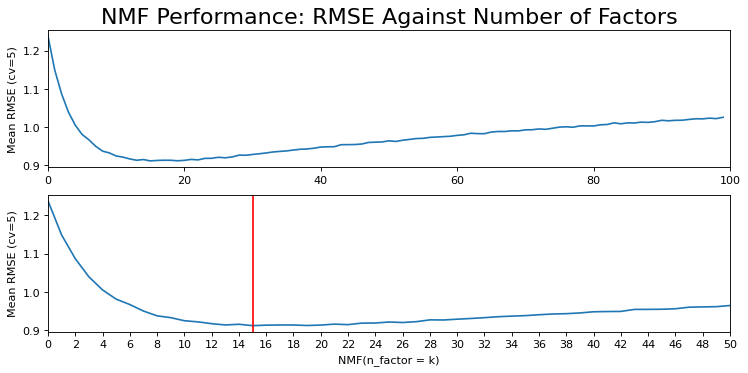

In [14]:
plot_rmse(rmse_nmf, "NMF")


In [15]:
param_grid = {'n_factors': [11,14,15,16,17,18,20]}
gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=5)
gs.fit(data)



# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9104064956353655
{'n_factors': 16}


In [16]:
algo_NMF = NMF(n_factors = 16)
algo_NMF.fit(trainset)


# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo_NMF.test(testset)

In [27]:
hist_NMF_124, pred_NMF_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)

User 124 has already rated 50 movies.


In [28]:
pred_NMF_124


,userId,movieId,rat_pred,title,genres
0,124,2959,5.0,Fight Club (1999),Action|Crime|Drama|Thriller
1,124,8207,5.0,"Day of the Jackal, The (1973)",Crime|Thriller
2,124,187,5.0,Party Girl (1995),Comedy
3,124,1148,5.0,Wallace & Gromit: The Wrong Trousers (1993),Animation|Children|Comedy|Crime
4,124,1245,5.0,Miller's Crossing (1990),Crime|Drama|Film-Noir|Thriller
5,124,53129,5.0,Mr. Brooks (2007),Crime|Drama|Thriller
6,124,56782,5.0,There Will Be Blood (2007),Drama|Western
7,124,1262,5.0,"Great Escape, The (1963)",Action|Adventure|Drama|War
8,124,3451,5.0,Guess Who's Coming to Dinner (1967),Drama
9,124,5747,5.0,Gallipoli (1981),Drama|War
